In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

dataset_dir = '/kaggle/input/cifar-100-c'
print(os.listdir(dataset_dir))

['motion_blur.npy', 'speckle_noise.npy', 'jpeg_compression.npy', 'impulse_noise.npy', 'defocus_blur.npy', 'brightness.npy', 'elastic_transform.npy', 'snow.npy', 'labels.npy', 'gaussian_blur.npy', 'README.txt', 'frost.npy', 'zoom_blur.npy', 'spatter.npy', 'fog.npy', 'gaussian_noise.npy', 'contrast.npy', 'saturate.npy', 'shot_noise.npy', 'pixelate.npy', 'glass_blur.npy']


In [2]:
!pip install torchmetrics
!git clone https://github.com/EkagraGupta/MasterArbeit.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/866.2 kB ? eta -:--:--

     ━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/866.2 kB 1.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━ 327.7/866.2 kB 3.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━ 757.8/866.2 kB 5.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 5.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


Cloning into 'MasterArbeit'...


remote: Enumerating objects: 1715, done.


remote: Counting objects: 100% (331/331), done.
remote: Compressing objects: 100% (222/222), done.


remote: Total 1715 (delta 109), reused 331 (delta 109), pack-reused 1384 (from 1)
Receiving objects: 100% (1715/1715), 594.13 MiB | 45.75 MiB/s, done.
Resolving deltas: 100% (772/772), done.


Updating files: 100% (168/168), done.


In [3]:
# Import statements
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import TrivialAugmentWide
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
import os

# Define the device
tpu = True

if tpu == True:
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
else:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  #intend here for else


class CustomDataset(Dataset):
    def __init__(self, np_images, original_dataset, resize):
        # Load images
        self.images = torch.from_numpy(np_images).permute(0, 3, 1, 2) / 255
         #Normalize the images
        #transform_test = transforms.Compose([
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        #])
        #self.images = transform_test(self.images)
        #if resize == True:
            #self.images = transforms.Resize(224, antialias=True)(self.images)
        
        # Extract labels from the original PyTorch dataset
        self.labels = [label for _, label in original_dataset]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Get image and label for the given index
        image = self.images[index]
        label = self.labels[index]

        return image, label

# Define the function to load corrupted datasets separately
def load_data_c_separately(dataset, testset, resize, test_transforms, batch_size):
    corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']
    np.asarray(corruptions)
    c_datasets = {}
    for corruption in corruptions:
        if dataset == 'CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
            np_data_c = np.array(np.array_split(np_data_c, 5))
            custom_dataset = CustomDataset(np_data_c[0], testset, resize)  # Load only one split for now
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)
            c_datasets[corruption] = custom_dataloader
        else:
            print('No corrupted benchmark available other than CIFAR10-c.')

    return c_datasets


# Load corrupted datasets
#corrupted_datasets = load_data_c(dataset='CIFAR10', testset=testset, resize=True, 
                                 #test_transforms=None, subset=False, subsetsize=None)

# Transformations for training and test sets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),  
    TrivialAugmentWide(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 512

# Use CIFAR-100 dataset for training
baseline_trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory=True)

# Use CIFAR-100 dataset for testing
baseline_testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, pin_memory=True)

%cd /kaggle/working/MasterArbeit
from augment_dataset import create_transforms, load_data
from compute_loss import soft_loss

"""
 Create the transformations based on the provided flags:
 - If all flags (random_cropping, aggressive_augmentation, and custom) are False:
   No augmentation other than default preprocessing is applied.
 - If random_cropping (rc) is True and the others (aa and custom) are False:
   Only random cropping is applied.
 - If random_cropping (rc) and aggressive_augmentation (aa) are True, and custom is False:
   Random cropping and conventional aggressive augmentation techniques (TA) are applied.
 - If all three flags (rc, aa, custom) are True:
   Random cropping and soft augmentation techniques (TA) are applied.
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is False:
   Only conventional aggressive augmentation techniques (TA) are applied (no soft labels).
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is True:
   Aggressive augmentation (TA) is applied with soft labeling.
"""

transforms_preprocess, transforms_augmentation = create_transforms(random_cropping=False, aggressive_augmentation=True, custom=True)
custom_trainset, custom_testset = load_data(transforms_preprocess=transforms_preprocess, transforms_augmentation=transforms_augmentation)
custom_trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
custom_testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
%cd

classes = baseline_trainset.classes


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


E0000 00:00:1724417128.445651      77 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:483


  0%|          | 0/169001437 [00:00<?, ?it/s]

  0%|          | 458752/169001437 [00:00<00:42, 3957803.11it/s]

  3%|▎         | 4882432/169001437 [00:00<00:06, 26141314.41it/s]

  6%|▌         | 10059776/169001437 [00:00<00:04, 37390703.14it/s]

 11%|█         | 17989632/169001437 [00:00<00:02, 53563739.44it/s]

 15%|█▍        | 25296896/169001437 [00:00<00:02, 60474308.12it/s]

 21%|██▏       | 35946496/169001437 [00:00<00:01, 75922257.05it/s]

 26%|██▌       | 43810816/169001437 [00:00<00:01, 76786062.67it/s]

 32%|███▏      | 54460416/169001437 [00:00<00:01, 85973943.70it/s]

 37%|███▋      | 63111168/169001437 [00:00<00:01, 85228414.29it/s]

 43%|████▎     | 72286208/169001437 [00:01<00:01, 87167485.48it/s]

 48%|████▊     | 81559552/169001437 [00:01<00:00, 88775186.87it/s]

 54%|█████▎    | 90472448/169001437 [00:01<00:00, 84857298.27it/s]

 59%|█████▉    | 99483648/169001437 [00:01<00:00, 86388697.72it/s]

 64%|██████▍   | 108167168/169001437 [00:01<00:00, 77598027.93it/s]

 69%|██████▉   | 116621312/169001437 [00:01<00:00, 79445513.86it/s]

 76%|███████▌  | 127729664/169001437 [00:01<00:00, 88321557.36it/s]

 81%|████████  | 136740864/169001437 [00:01<00:00, 87321156.71it/s]

 87%|████████▋ | 147652608/169001437 [00:01<00:00, 93362838.42it/s]

 93%|█████████▎| 157122560/169001437 [00:01<00:00, 92007421.86it/s]

 98%|█████████▊| 166428672/169001437 [00:02<00:00, 91230466.09it/s]

100%|██████████| 169001437/169001437 [00:02<00:00, 79444243.01it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


Files already downloaded and verified


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/kaggle/working/MasterArbeit


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 458752/170498071 [00:00<00:42, 3997144.35it/s]

  4%|▍         | 7045120/170498071 [00:00<00:04, 38257189.55it/s]

 11%|█         | 18022400/170498071 [00:00<00:02, 69800321.46it/s]

 17%|█▋        | 29065216/170498071 [00:00<00:01, 85447560.17it/s]

 24%|██▎       | 40173568/170498071 [00:00<00:01, 94549757.13it/s]

 30%|███       | 51281920/170498071 [00:00<00:01, 100028813.10it/s]

 36%|███▋      | 61997056/170498071 [00:00<00:01, 102223891.63it/s]

 42%|████▏     | 72384512/170498071 [00:00<00:00, 102692458.84it/s]

 49%|████▊     | 82706432/170498071 [00:00<00:00, 100929510.52it/s]

 54%|█████▍    | 92831744/170498071 [00:01<00:00, 91487815.01it/s] 

 61%|██████    | 103809024/170498071 [00:01<00:00, 96608692.65it/s]

 67%|██████▋   | 114786304/170498071 [00:01<00:00, 100376807.41it/s]

 74%|███████▍  | 125829120/170498071 [00:01<00:00, 103210060.40it/s]

 80%|████████  | 136773632/170498071 [00:01<00:00, 105016315.76it/s]

 87%|████████▋ | 147750912/170498071 [00:01<00:00, 106318439.72it/s]

 93%|█████████▎| 158695424/170498071 [00:01<00:00, 107226929.50it/s]

 99%|█████████▉| 169639936/170498071 [00:01<00:00, 107793514.00it/s]

100%|██████████| 170498071/170498071 [00:01<00:00, 96454999.36it/s] 

Extracting ./data/train/cifar-10-python.tar.gz to ./data/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 458752/170498071 [00:00<00:41, 4079483.17it/s]

  3%|▎         | 5734400/170498071 [00:00<00:05, 31313008.32it/s]

  7%|▋         | 11993088/170498071 [00:00<00:03, 45156423.05it/s]

 11%|█         | 18874368/170498071 [00:00<00:02, 54305381.38it/s]

 15%|█▍        | 25100288/170498071 [00:00<00:02, 57018396.04it/s]

 19%|█▊        | 31916032/170498071 [00:00<00:02, 60710272.12it/s]

 22%|██▏       | 38043648/170498071 [00:00<00:02, 60636323.10it/s]

 26%|██▌       | 44204032/170498071 [00:00<00:02, 60929651.90it/s]

 30%|██▉       | 50331648/170498071 [00:00<00:02, 55261604.12it/s]

 33%|███▎      | 55967744/170498071 [00:01<00:02, 51781452.21it/s]

 37%|███▋      | 62980096/170498071 [00:01<00:01, 56661347.32it/s]

 41%|████      | 69271552/170498071 [00:01<00:01, 58417240.54it/s]

 45%|████▍     | 76218368/170498071 [00:01<00:01, 61390195.62it/s]

 49%|████▊     | 82706432/170498071 [00:01<00:01, 62353226.65it/s]

 53%|█████▎    | 89522176/170498071 [00:01<00:01, 64048478.39it/s]

 56%|█████▋    | 95977472/170498071 [00:01<00:01, 63906475.60it/s]

 60%|██████    | 102629376/170498071 [00:01<00:01, 64442251.34it/s]

 64%|██████▍   | 109117440/170498071 [00:01<00:00, 63303492.02it/s]

 68%|██████▊   | 115474432/170498071 [00:02<00:00, 56065535.16it/s]

 72%|███████▏  | 122093568/170498071 [00:02<00:00, 58782186.52it/s]

 78%|███████▊  | 133005312/170498071 [00:02<00:00, 72391838.78it/s]

 85%|████████▍ | 144441344/170498071 [00:02<00:00, 84221193.64it/s]

 91%|█████████▏| 155746304/170498071 [00:02<00:00, 92439436.48it/s]

 98%|█████████▊| 167018496/170498071 [00:02<00:00, 98333741.55it/s]

100%|██████████| 170498071/170498071 [00:02<00:00, 66403925.58it/s]

Extracting ./data/test/cifar-10-python.tar.gz to ./data/test


/root


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:428: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
print(transforms_augmentation)

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=4)
)


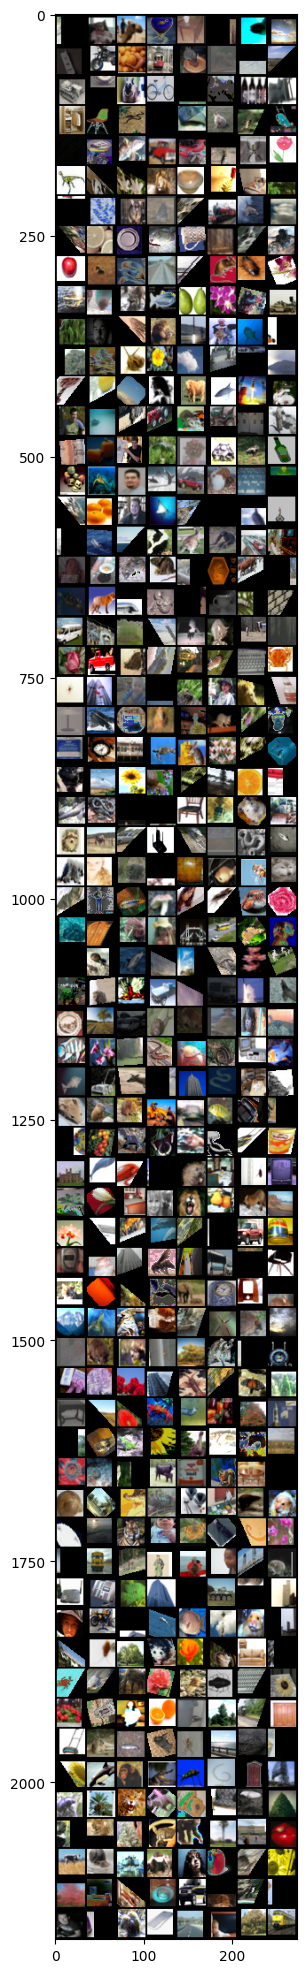

baby  baby  camel cup   table clock seal  plain telephone motorcycle orange streetcar porcupine tractor cloud plain tractor plate rabbit bicycle raccoon mountain bottle chair wardrobe chair snake kangaroo ray   fox   spider lawn_mower caterpillar can   shark pickup_truck lawn_mower leopard spider plate dinosaur rabbit tulip lion  bowl  rose  bed   forest lawn_mower willow_tree possum butterfly fox   train dolphin cloud bicycle orange plate flatfish cup   forest otter tractor apple skunk snake road  bridge mouse cockroach orchid whale seal  raccoon trout pear  orchid lawn_mower tank  willow_tree man   dinosaur lion  rocket flatfish dolphin lawn_mower oak_tree pine_tree snail poppy cloud house mountain sea   cup   apple cloud woman cattle whale rocket orchid man   ray   cattle tractor possum lawn_mower couch otter castle sweet_pepper man   dinosaur rose  chimpanzee skunk bottle sweet_pepper turtle man   dolphin pickup_truck hamster keyboard cup   bus   orange man   ray   leopard raccoon 

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(20, 25))  # Adjust the width and height as needed
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
# dataiter = iter(custom_trainloader)
# images, labels, confidences = next(dataiter)

# if training baseline model, uncomment this
dataiter = iter(baseline_trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels 
# if isinstance(confidences, list):
#     # in case we have confidence 
#     confidences = confidences[1]
    
# print(' '.join(f'{classes[labels[j]]:5s}: {confidences[j].item():.2f}' for j in range(batch_size)))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np


# Manual implementation of ResNet18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling layer
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)  # Apply global average pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



# ResNet18 Architecture
def ResNet18(num_classes=100):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform(m.weight, gain=np.sqrt(2))
        init.constant(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant(m.weight, 1)
        init.constant(m.bias, 0)

class WideBasic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(WideBasic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate=0.3, num_classes=100, factor=1, block=WideBasic):
        super(WideResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (int)((depth-4)/6)
        k = widen_factor

        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0], stride=1)
        self.layer1 = self._wide_layer(block, nStages[1], n, dropout_rate, stride=factor)
        self.layer2 = self._wide_layer(block, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(block, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

def WideResNet_28_4(num_classes, factor=1, block=WideBasic, dropout_rate=0.3):
    return WideResNet(depth=28, widen_factor=4, dropout_rate=dropout_rate, num_classes=num_classes, factor=factor, block=block)

Model Training

In [8]:
# Initialize the model
net = WideResNet_28_4(num_classes=100)
net.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): WideBasic(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): WideBasic(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, ke

In [9]:
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.15, momentum=0.9, weight_decay=1e-4)

# Initialize the scheduler
epochs = 100
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # Cosine Annealing LR Scheduler

# Training loop
print(f'\nStart Training...\n')
for epoch in range(epochs):  # loop over the dataset multiple times
    
    start_time = time.time()
    
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    total = 0
    correct = 0
    
    net.train()
    for i, (inputs, labels) in enumerate(baseline_trainloader):
#     for i, (inputs, labels, confidences) in enumerate(custom_trainloader):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # when the model returns [augmentation_magnitude, confidence_aa], which is the case
        # only when TA with soft labels is applied
#         if isinstance(confidences, list):
#             confidences = confidences[1]
            
        # get the inputs
#         inputs, labels, confidences = inputs.to(device), labels.to(device), confidences.to(device)
        inputs, labels = inputs.to(device), labels.to(device)
    
        # Convert labels to one-hot encoded vectors
#         labels_one_hot = F.one_hot(labels, num_classes=10).float()
        
        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)  
#         loss = soft_loss(pred=outputs, label=labels, confidence=confidences)
#         print(f'Loss: {loss:.3f}\tHard Loss: {hard_loss:.3f}')

        loss.backward()
        optimizer.step()
        if tpu:
            xm.mark_step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    with torch.no_grad():
        net.eval()
        for images, labels in baseline_testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # calculate and print average loss for current epoch
    average_loss = running_loss / len(custom_trainloader)
    
    print(f'\nEpoch {epoch + 1} - Loss: {average_loss:.3f} - Test Accuracy: {100 * correct / total: .3f}')    
    
    scheduler.step()
    end_time = time.time()
    print(f'\nProcessing time: {(end_time - start_time): 3f} seconds.')

print('Finished Training')

# Save the trained model
PATH = '/kaggle/working/cifar100_net_ta_pytorch_100.pth'
torch.save(net.state_dict(), PATH)


Start Training...




Epoch 1 - Loss: 4.323 - Test Accuracy:  4.060

Processing time:  69.585483 seconds.



Epoch 2 - Loss: 4.025 - Test Accuracy:  8.930

Processing time:  37.627689 seconds.



Epoch 3 - Loss: 3.811 - Test Accuracy:  12.750

Processing time:  18.923394 seconds.



Epoch 4 - Loss: 3.584 - Test Accuracy:  17.400

Processing time:  18.104757 seconds.



Epoch 5 - Loss: 3.352 - Test Accuracy:  17.830

Processing time:  17.638472 seconds.



Epoch 6 - Loss: 3.133 - Test Accuracy:  18.600

Processing time:  17.616002 seconds.



Epoch 7 - Loss: 2.945 - Test Accuracy:  19.580

Processing time:  18.586652 seconds.



Epoch 8 - Loss: 2.776 - Test Accuracy:  23.160

Processing time:  17.621573 seconds.



Epoch 9 - Loss: 2.632 - Test Accuracy:  30.820

Processing time:  17.774427 seconds.



Epoch 10 - Loss: 2.506 - Test Accuracy:  31.840

Processing time:  17.929734 seconds.



Epoch 11 - Loss: 2.401 - Test Accuracy:  27.540

Processing time:  17.881231 seconds.



Epoch 12 - Loss: 2.302 - Test Accuracy:  32.530

Processing time:  17.833632 seconds.



Epoch 13 - Loss: 2.225 - Test Accuracy:  22.500

Processing time:  17.817529 seconds.



Epoch 14 - Loss: 2.135 - Test Accuracy:  35.820

Processing time:  17.721078 seconds.



Epoch 15 - Loss: 2.084 - Test Accuracy:  41.520

Processing time:  17.744226 seconds.



Epoch 16 - Loss: 2.013 - Test Accuracy:  36.720

Processing time:  17.730443 seconds.



Epoch 17 - Loss: 1.952 - Test Accuracy:  43.810

Processing time:  17.763841 seconds.



Epoch 18 - Loss: 1.905 - Test Accuracy:  46.390

Processing time:  17.642944 seconds.



Epoch 19 - Loss: 1.857 - Test Accuracy:  51.780

Processing time:  17.611808 seconds.



Epoch 20 - Loss: 1.812 - Test Accuracy:  51.430

Processing time:  18.008403 seconds.



Epoch 21 - Loss: 1.776 - Test Accuracy:  52.760

Processing time:  18.050495 seconds.



Epoch 22 - Loss: 1.741 - Test Accuracy:  52.600

Processing time:  17.753964 seconds.



Epoch 23 - Loss: 1.707 - Test Accuracy:  54.880

Processing time:  17.646260 seconds.



Epoch 24 - Loss: 1.655 - Test Accuracy:  55.160

Processing time:  17.584017 seconds.



Epoch 25 - Loss: 1.629 - Test Accuracy:  61.120

Processing time:  17.530519 seconds.



Epoch 26 - Loss: 1.602 - Test Accuracy:  58.520

Processing time:  17.499027 seconds.



Epoch 27 - Loss: 1.575 - Test Accuracy:  57.800

Processing time:  17.764296 seconds.



Epoch 28 - Loss: 1.540 - Test Accuracy:  58.460

Processing time:  17.850782 seconds.



Epoch 29 - Loss: 1.517 - Test Accuracy:  59.150

Processing time:  17.753208 seconds.



Epoch 30 - Loss: 1.494 - Test Accuracy:  61.810

Processing time:  17.908889 seconds.



Epoch 31 - Loss: 1.470 - Test Accuracy:  64.740

Processing time:  17.936342 seconds.



Epoch 32 - Loss: 1.440 - Test Accuracy:  66.590

Processing time:  17.653523 seconds.



Epoch 33 - Loss: 1.430 - Test Accuracy:  63.190

Processing time:  17.932477 seconds.



Epoch 34 - Loss: 1.389 - Test Accuracy:  63.600

Processing time:  17.759436 seconds.



Epoch 35 - Loss: 1.368 - Test Accuracy:  63.230

Processing time:  18.056790 seconds.



Epoch 36 - Loss: 1.355 - Test Accuracy:  63.750

Processing time:  17.912363 seconds.



Epoch 37 - Loss: 1.340 - Test Accuracy:  65.180

Processing time:  18.304914 seconds.



Epoch 38 - Loss: 1.329 - Test Accuracy:  66.330

Processing time:  17.515610 seconds.



Epoch 39 - Loss: 1.310 - Test Accuracy:  62.890

Processing time:  17.503088 seconds.



Epoch 40 - Loss: 1.290 - Test Accuracy:  65.680

Processing time:  17.994285 seconds.



Epoch 41 - Loss: 1.263 - Test Accuracy:  66.170

Processing time:  18.023858 seconds.



Epoch 42 - Loss: 1.255 - Test Accuracy:  67.040

Processing time:  17.888882 seconds.



Epoch 43 - Loss: 1.228 - Test Accuracy:  64.430

Processing time:  17.720734 seconds.



Epoch 44 - Loss: 1.217 - Test Accuracy:  67.110

Processing time:  17.797368 seconds.



Epoch 45 - Loss: 1.198 - Test Accuracy:  67.910

Processing time:  17.895586 seconds.



Epoch 46 - Loss: 1.182 - Test Accuracy:  67.780

Processing time:  17.823886 seconds.



Epoch 47 - Loss: 1.174 - Test Accuracy:  67.940

Processing time:  17.807044 seconds.



Epoch 48 - Loss: 1.153 - Test Accuracy:  66.170

Processing time:  17.835537 seconds.



Epoch 49 - Loss: 1.134 - Test Accuracy:  68.730

Processing time:  17.668049 seconds.



Epoch 50 - Loss: 1.119 - Test Accuracy:  69.060

Processing time:  17.599869 seconds.



Epoch 51 - Loss: 1.086 - Test Accuracy:  67.850

Processing time:  17.535358 seconds.



Epoch 52 - Loss: 1.082 - Test Accuracy:  70.650

Processing time:  17.591882 seconds.



Epoch 53 - Loss: 1.074 - Test Accuracy:  70.500

Processing time:  17.825032 seconds.



Epoch 54 - Loss: 1.051 - Test Accuracy:  70.830

Processing time:  17.752556 seconds.



Epoch 55 - Loss: 1.053 - Test Accuracy:  69.080

Processing time:  17.760480 seconds.



Epoch 56 - Loss: 1.030 - Test Accuracy:  70.650

Processing time:  17.866140 seconds.



Epoch 57 - Loss: 1.014 - Test Accuracy:  70.840

Processing time:  17.860505 seconds.



Epoch 58 - Loss: 0.989 - Test Accuracy:  71.640

Processing time:  17.851210 seconds.



Epoch 59 - Loss: 0.981 - Test Accuracy:  71.650

Processing time:  17.771617 seconds.



Epoch 60 - Loss: 0.967 - Test Accuracy:  71.810

Processing time:  18.021385 seconds.



Epoch 61 - Loss: 0.954 - Test Accuracy:  72.300

Processing time:  17.857283 seconds.



Epoch 62 - Loss: 0.937 - Test Accuracy:  72.600

Processing time:  17.697433 seconds.



Epoch 63 - Loss: 0.930 - Test Accuracy:  72.320

Processing time:  18.276457 seconds.



Epoch 64 - Loss: 0.919 - Test Accuracy:  71.300

Processing time:  17.709461 seconds.



Epoch 65 - Loss: 0.896 - Test Accuracy:  71.910

Processing time:  17.704264 seconds.



Epoch 66 - Loss: 0.890 - Test Accuracy:  73.830

Processing time:  17.651028 seconds.



Epoch 67 - Loss: 0.878 - Test Accuracy:  73.010

Processing time:  17.855441 seconds.



Epoch 68 - Loss: 0.864 - Test Accuracy:  72.630

Processing time:  17.644696 seconds.



Epoch 69 - Loss: 0.856 - Test Accuracy:  72.670

Processing time:  17.978339 seconds.



Epoch 70 - Loss: 0.836 - Test Accuracy:  73.900

Processing time:  17.904185 seconds.



Epoch 71 - Loss: 0.825 - Test Accuracy:  73.770

Processing time:  17.639562 seconds.



Epoch 72 - Loss: 0.825 - Test Accuracy:  73.120

Processing time:  18.849359 seconds.



Epoch 73 - Loss: 0.800 - Test Accuracy:  74.270

Processing time:  17.942781 seconds.



Epoch 74 - Loss: 0.801 - Test Accuracy:  74.860

Processing time:  17.755662 seconds.



Epoch 75 - Loss: 0.778 - Test Accuracy:  73.580

Processing time:  17.829774 seconds.



Epoch 76 - Loss: 0.768 - Test Accuracy:  74.440

Processing time:  17.831701 seconds.



Epoch 77 - Loss: 0.763 - Test Accuracy:  74.200

Processing time:  18.695657 seconds.



Epoch 78 - Loss: 0.758 - Test Accuracy:  74.890

Processing time:  17.822188 seconds.



Epoch 79 - Loss: 0.732 - Test Accuracy:  75.460

Processing time:  17.748326 seconds.



Epoch 80 - Loss: 0.737 - Test Accuracy:  75.240

Processing time:  17.876308 seconds.



Epoch 81 - Loss: 0.724 - Test Accuracy:  75.590

Processing time:  17.848386 seconds.



Epoch 82 - Loss: 0.716 - Test Accuracy:  75.220

Processing time:  17.798671 seconds.



Epoch 83 - Loss: 0.713 - Test Accuracy:  75.660

Processing time:  17.702782 seconds.



Epoch 84 - Loss: 0.714 - Test Accuracy:  75.580

Processing time:  18.509712 seconds.



Epoch 85 - Loss: 0.693 - Test Accuracy:  75.970

Processing time:  17.831566 seconds.



Epoch 86 - Loss: 0.701 - Test Accuracy:  76.460

Processing time:  17.841457 seconds.



Epoch 87 - Loss: 0.689 - Test Accuracy:  76.520

Processing time:  17.849743 seconds.



Epoch 88 - Loss: 0.687 - Test Accuracy:  75.910

Processing time:  17.859365 seconds.



Epoch 89 - Loss: 0.669 - Test Accuracy:  76.400

Processing time:  17.935236 seconds.



Epoch 90 - Loss: 0.661 - Test Accuracy:  76.260

Processing time:  17.721553 seconds.



Epoch 91 - Loss: 0.662 - Test Accuracy:  76.010

Processing time:  17.976857 seconds.



Epoch 92 - Loss: 0.660 - Test Accuracy:  76.280

Processing time:  18.270703 seconds.



Epoch 93 - Loss: 0.654 - Test Accuracy:  76.410

Processing time:  18.097606 seconds.



Epoch 94 - Loss: 0.654 - Test Accuracy:  76.340

Processing time:  17.862008 seconds.



Epoch 95 - Loss: 0.654 - Test Accuracy:  76.360

Processing time:  18.043056 seconds.



Epoch 96 - Loss: 0.649 - Test Accuracy:  76.540

Processing time:  17.697889 seconds.



Epoch 97 - Loss: 0.652 - Test Accuracy:  76.390

Processing time:  17.794947 seconds.



Epoch 98 - Loss: 0.656 - Test Accuracy:  76.370

Processing time:  17.989889 seconds.



Epoch 99 - Loss: 0.644 - Test Accuracy:  76.370

Processing time:  17.965408 seconds.



Epoch 100 - Loss: 0.658 - Test Accuracy:  76.410

Processing time:  17.755802 seconds.
Finished Training


Evaluate the model on Testset

In [10]:
import torch
import numpy as np

# Evaluate the CIFAR-100 dataset
correct = 0
total = 0

with torch.no_grad():
    net.eval()
    for images, labels in baseline_testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    if total == 0:
        print('No images found for CIFAR-100 dataset.')
    else:
        cifar10_accuracy = 100 * correct / total
        print(f'Accuracy of the network on the CIFAR-100 test dataset: {cifar10_accuracy:.2f} %')

if not tpu:
    # Clear GPU memory
    torch.cuda.empty_cache()

    # Clear CPU memory
    torch.cuda.ipc_collect()

# Define the list of corruptions
corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
               'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
               'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
               'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# Define the batch size
batch_size = 256 

# Create an empty dictionary to store corrupted datasets
corrupted_datasets = {}

# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# List to store average accuracies for each corruption dataset
average_accuracies = []

# Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
for corruption in corruptions:
    print(f"Testing on corruption: {corruption}")

    # Load and test datasets for all 5 severity levels of the current corruption
    try:
        np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
        np_data_c_splits = np.array_split(np_data_c, 5)
        
        # List to store accuracies of all severity levels for averaging
        accuracies = []

        for i, np_data_c_split in enumerate(np_data_c_splits):
            custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

            # Testing loop for the current corruption dataset split
            correct = 0
            total = 0

            with torch.no_grad():
                images_loaded = 0  # Counter for images loaded for the current corruption
                for images, labels in custom_dataloader:
                    images_loaded += len(images)  # Increment the counter by the number of images loaded
                    images, labels = images.to(device), labels.to(device)
                    # Calculate outputs by running images through the network
                    outputs = net(images)
                    # The class with the highest energy is chosen as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                if total == 0:
                    print(f'No images found for {corruption} dataset split {i+1}.')
                else:
                    accuracy = 100 * correct / total
                    print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
                    accuracies.append(accuracy)

                # Print the number of images loaded for the current corruption dataset split
                #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
                if not tpu:
                    # Clear GPU memory
                    torch.cuda.empty_cache()
                    # Clear CPU memory
                    torch.cuda.ipc_collect()

                # Delete variables to free up memory
                del custom_dataset
                del custom_dataloader

        # Calculate and print the average accuracy for the corruption dataset
        if accuracies:
            average_accuracy = sum(accuracies) / len(accuracies)
            average_accuracies.append(average_accuracy)
            print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

    except FileNotFoundError:
        print(f'Corruption {corruption} dataset not found.')
        continue

# Calculate and print the average robust accuracy
if average_accuracies:
    average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
    print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
else:
    print("No corrupt datasets found for evaluation.")

Accuracy of the network on the CIFAR-100 test dataset: 76.41 %
Testing on corruption: gaussian_noise


Accuracy of the network on gaussian_noise dataset split 1: 55.62 %


Accuracy of the network on gaussian_noise dataset split 2: 41.30 %


Accuracy of the network on gaussian_noise dataset split 3: 28.94 %


Accuracy of the network on gaussian_noise dataset split 4: 24.04 %


Accuracy of the network on gaussian_noise dataset split 5: 20.07 %
Average accuracy for gaussian_noise dataset: 33.99 %
Testing on corruption: shot_noise


Accuracy of the network on shot_noise dataset split 1: 63.00 %


Accuracy of the network on shot_noise dataset split 2: 53.80 %


Accuracy of the network on shot_noise dataset split 3: 36.36 %


Accuracy of the network on shot_noise dataset split 4: 31.13 %


Accuracy of the network on shot_noise dataset split 5: 23.14 %
Average accuracy for shot_noise dataset: 41.49 %
Testing on corruption: impulse_noise


Accuracy of the network on impulse_noise dataset split 1: 70.84 %


Accuracy of the network on impulse_noise dataset split 2: 62.34 %


Accuracy of the network on impulse_noise dataset split 3: 51.71 %


Accuracy of the network on impulse_noise dataset split 4: 30.93 %


Accuracy of the network on impulse_noise dataset split 5: 18.76 %
Average accuracy for impulse_noise dataset: 46.92 %
Testing on corruption: defocus_blur


Accuracy of the network on defocus_blur dataset split 1: 76.12 %


Accuracy of the network on defocus_blur dataset split 2: 74.50 %


Accuracy of the network on defocus_blur dataset split 3: 71.05 %


Accuracy of the network on defocus_blur dataset split 4: 65.24 %


Accuracy of the network on defocus_blur dataset split 5: 52.36 %
Average accuracy for defocus_blur dataset: 67.85 %
Testing on corruption: glass_blur


Accuracy of the network on glass_blur dataset split 1: 49.18 %


Accuracy of the network on glass_blur dataset split 2: 50.62 %


Accuracy of the network on glass_blur dataset split 3: 53.19 %


Accuracy of the network on glass_blur dataset split 4: 34.87 %


Accuracy of the network on glass_blur dataset split 5: 37.96 %
Average accuracy for glass_blur dataset: 45.16 %
Testing on corruption: motion_blur


Accuracy of the network on motion_blur dataset split 1: 71.08 %


Accuracy of the network on motion_blur dataset split 2: 65.01 %


Accuracy of the network on motion_blur dataset split 3: 57.91 %


Accuracy of the network on motion_blur dataset split 4: 57.71 %


Accuracy of the network on motion_blur dataset split 5: 50.07 %
Average accuracy for motion_blur dataset: 60.36 %
Testing on corruption: zoom_blur


Accuracy of the network on zoom_blur dataset split 1: 70.63 %


Accuracy of the network on zoom_blur dataset split 2: 69.21 %


Accuracy of the network on zoom_blur dataset split 3: 66.18 %


Accuracy of the network on zoom_blur dataset split 4: 62.68 %


Accuracy of the network on zoom_blur dataset split 5: 56.55 %
Average accuracy for zoom_blur dataset: 65.05 %
Testing on corruption: snow


Accuracy of the network on snow dataset split 1: 71.43 %


Accuracy of the network on snow dataset split 2: 60.42 %


Accuracy of the network on snow dataset split 3: 62.11 %


Accuracy of the network on snow dataset split 4: 59.50 %


Accuracy of the network on snow dataset split 5: 53.00 %
Average accuracy for snow dataset: 61.29 %
Testing on corruption: frost


Accuracy of the network on frost dataset split 1: 68.83 %


Accuracy of the network on frost dataset split 2: 61.82 %


Accuracy of the network on frost dataset split 3: 51.28 %


Accuracy of the network on frost dataset split 4: 48.62 %


Accuracy of the network on frost dataset split 5: 39.95 %
Average accuracy for frost dataset: 54.10 %
Testing on corruption: fog


Accuracy of the network on fog dataset split 1: 75.76 %


Accuracy of the network on fog dataset split 2: 73.52 %


Accuracy of the network on fog dataset split 3: 71.13 %


Accuracy of the network on fog dataset split 4: 65.20 %


Accuracy of the network on fog dataset split 5: 47.14 %
Average accuracy for fog dataset: 66.55 %
Testing on corruption: brightness


Accuracy of the network on brightness dataset split 1: 76.23 %


Accuracy of the network on brightness dataset split 2: 75.44 %


Accuracy of the network on brightness dataset split 3: 74.28 %


Accuracy of the network on brightness dataset split 4: 72.60 %


Accuracy of the network on brightness dataset split 5: 68.12 %
Average accuracy for brightness dataset: 73.33 %
Testing on corruption: contrast


Accuracy of the network on contrast dataset split 1: 74.95 %


Accuracy of the network on contrast dataset split 2: 71.75 %


Accuracy of the network on contrast dataset split 3: 69.29 %


Accuracy of the network on contrast dataset split 4: 65.47 %


Accuracy of the network on contrast dataset split 5: 51.65 %
Average accuracy for contrast dataset: 66.62 %
Testing on corruption: elastic_transform


Accuracy of the network on elastic_transform dataset split 1: 69.69 %


Accuracy of the network on elastic_transform dataset split 2: 70.02 %


Accuracy of the network on elastic_transform dataset split 3: 67.64 %


Accuracy of the network on elastic_transform dataset split 4: 60.06 %


Accuracy of the network on elastic_transform dataset split 5: 52.55 %
Average accuracy for elastic_transform dataset: 63.99 %
Testing on corruption: pixelate


Accuracy of the network on pixelate dataset split 1: 73.07 %


Accuracy of the network on pixelate dataset split 2: 65.10 %


Accuracy of the network on pixelate dataset split 3: 58.73 %


Accuracy of the network on pixelate dataset split 4: 38.67 %


Accuracy of the network on pixelate dataset split 5: 18.36 %
Average accuracy for pixelate dataset: 50.79 %
Testing on corruption: jpeg_compression


Accuracy of the network on jpeg_compression dataset split 1: 59.90 %


Accuracy of the network on jpeg_compression dataset split 2: 52.26 %


Accuracy of the network on jpeg_compression dataset split 3: 49.50 %


Accuracy of the network on jpeg_compression dataset split 4: 46.48 %


Accuracy of the network on jpeg_compression dataset split 5: 43.44 %
Average accuracy for jpeg_compression dataset: 50.32 %
Testing on corruption: speckle_noise


Accuracy of the network on speckle_noise dataset split 1: 63.65 %


Accuracy of the network on speckle_noise dataset split 2: 49.82 %


Accuracy of the network on speckle_noise dataset split 3: 43.85 %


Accuracy of the network on speckle_noise dataset split 4: 32.21 %


Accuracy of the network on speckle_noise dataset split 5: 23.85 %
Average accuracy for speckle_noise dataset: 42.68 %
Testing on corruption: gaussian_blur


Accuracy of the network on gaussian_blur dataset split 1: 76.09 %


Accuracy of the network on gaussian_blur dataset split 2: 70.88 %


Accuracy of the network on gaussian_blur dataset split 3: 66.13 %


Accuracy of the network on gaussian_blur dataset split 4: 60.63 %


Accuracy of the network on gaussian_blur dataset split 5: 46.29 %
Average accuracy for gaussian_blur dataset: 64.00 %
Testing on corruption: spatter


Accuracy of the network on spatter dataset split 1: 74.26 %


Accuracy of the network on spatter dataset split 2: 70.03 %


Accuracy of the network on spatter dataset split 3: 62.62 %


Accuracy of the network on spatter dataset split 4: 69.15 %


Accuracy of the network on spatter dataset split 5: 60.08 %
Average accuracy for spatter dataset: 67.23 %
Testing on corruption: saturate


Accuracy of the network on saturate dataset split 1: 68.82 %


Accuracy of the network on saturate dataset split 2: 61.91 %


Accuracy of the network on saturate dataset split 3: 74.15 %


Accuracy of the network on saturate dataset split 4: 67.95 %


Accuracy of the network on saturate dataset split 5: 59.94 %
Average accuracy for saturate dataset: 66.55 %
Average Robust Accuracy: 57.28 %
